# RTI International Analytics Exercise
### Author: Sam Eure
### Date: May 31, 2019

In [1]:
import sqlite3
conn = sqlite3.connect('exercise01.sqlite')
cur = conn.cursor()

In [2]:
#SQLite query onsolidating the data into a single table using inner joins
query = cur.execute('SELECT records.id, records.over_50k, records.education_num, \
                        records.capital_gain, records.capital_loss, records.hours_week, records.age,\
                        workclasses.name AS workclass, \
                        education_levels.name AS education_level,\
                        marital_statuses.name AS marital_status,\
                        occupations.name AS occupation,\
                        relationships.name AS relationship,\
                        races.name AS race,\
                        sexes.name AS sex,\
                        countries.name AS country\
                        FROM records\
                        INNER JOIN workclasses ON workclasses.id = records.workclass_id\
                        INNER JOIN education_levels ON education_levels.id = records.education_level_id\
                        INNER JOIN marital_statuses ON marital_statuses.id = records.marital_status_id\
                        INNER JOIN occupations ON occupations.id = records.occupation_id\
                        INNER JOIN relationships ON relationships.id = records.relationship_id\
                        INNER JOIN races ON races.id = records.race_id\
                        INNER JOIN sexes ON sexes.id = records.sex_id\
                        INNER JOIN countries ON countries.id = records.country_id;').fetchall()

In [107]:
import pandas as pd
import numpy as np

#Turn the list of the output from the query into a dataframe

columnNames = ["id","over_50k","education_num","capital_gain","capital_loss",
                "hours_week","age","workclass","education_level","marital_status",
                 "occupation","relationship","race","sex","country"]
df = pd.DataFrame(data = query, columns = columnNames)

#Column Headers


df.columns = columnNames

#Saving the data to a CSV
df.to_csv("data.csv", sep = ',', index = False)

#Showing the results
df.head()

,id,over_50k,education_num,capital_gain,capital_loss,hours_week,age,workclass,education_level,marital_status,occupation,relationship,race,sex,country
0,1,0,13,2174,0,40,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States
1,2,0,13,0,0,13,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
2,3,0,9,0,0,40,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States
3,4,0,7,0,0,40,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
4,5,0,13,0,0,40,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba


In [108]:
#Now I'll look at the data types
df.dtypes

id                  int64
over_50k            int64
education_num       int64
capital_gain        int64
capital_loss        int64
hours_week          int64
age                 int64
workclass          object
education_level    object
marital_status     object
occupation         object
relationship       object
race               object
sex                object
country            object
dtype: object

In [109]:
#Fraction of workers that make over 50k
1.0 - np.mean(df.over_50k.tolist())

0.7607182343065395

In [110]:
#I'm going to grab only the rows with NO missing values. This will be a DataFrame with complete entries.
completeDf = df.copy()
for c in columnNames:
    completeDf = completeDf[completeDf[c].apply(lambda v: v != "?")]
print("Number of complete entries: ", len(completeDf))
print("Number of incomplete entries:", len(df) - len(completeDf))

Number of complete entries:  45222
Number of incomplete entries: 3620


In [111]:
#Fraction of complete workers that make over 50k
1.0 - np.mean(completeDf.over_50k.tolist())

0.7521560302507629

In [6]:
import matplotlib.pyplot as plt

columns = completeDf.columns.tolist()
for j in range(len(columns)):
    if columns[j] in 'id, capital_gain, capital_loss, over_50k':
        continue;
    means = completeDf.groupby(columns[j]).mean().over_50k.tolist()
    names = completeDf[columns[j]].unique().tolist()
    names.sort()
    fig = plt.figure(figsize = (15,5))
    plt.bar(names,means)
    plt.title("Frequency of Over 50K by "+columns[j], fontsize = 20)
    plt.xlabel(columns[j], fontsize = 15)
    plt.ylabel("Fraction Over 50k", fontsize = 15)

#### Although I can't see what the labels at the bottom of all the figures above state, I can tell that the frequency of workers making over 50K a year depend on the variables being plotted.

#### I'll use some machine learning techniques to create a classification model for determining if an individual earns over 50 K dollars a year based on their census level data. 

#### To handle categorical variables, I'll use one hot encoding. However, first, I'll exclude the variable 'education_level' from the analysis since this information is directly related to education_num, which I believe can be well represented by a numerical data point. 

In [7]:
colIndex = list(set(columns) - {'id', 'education_level'})
cleanDf = completeDf[colIndex]
cleanDf.head()

,hours_week,workclass,country,over_50k,capital_gain,capital_loss,education_num,relationship,age,marital_status,sex,race,occupation
0,40,State-gov,United-States,0,2174,0,13,Not-in-family,39,Never-married,Male,White,Adm-clerical
1,13,Self-emp-not-inc,United-States,0,0,0,13,Husband,50,Married-civ-spouse,Male,White,Exec-managerial
2,40,Private,United-States,0,0,0,9,Not-in-family,38,Divorced,Male,White,Handlers-cleaners
3,40,Private,United-States,0,0,0,7,Husband,53,Married-civ-spouse,Male,Black,Handlers-cleaners
4,40,Private,Cuba,0,0,0,13,Wife,28,Married-civ-spouse,Female,Black,Prof-specialty


#### One Hot Encoding

In [8]:
hotCleanDf = pd.get_dummies(cleanDf)
print("Now I Have ",len(hotCleanDf.columns), " features instead of ", len(cleanDf.columns), "features. \n\n hotCleanDf.head()")
hotCleanDf.head()

Now I Have  88  features instead of  13 features. 

 hotCleanDf.head()


,hours_week,over_50k,capital_gain,capital_loss,education_num,age,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving
0,40,0,2174,0,13,39,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,13,0,0,0,13,50,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,40,0,0,0,9,38,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,40,0,0,0,7,53,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4,40,0,0,0,13,28,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


#### Next, I'll divide my data set into a train, validation, and test data sets. I'll used the cleanDf (which is contains the data points with complete entries) as my data set.

In [146]:
import random

random.seed(1)
indices = list(range(len(cleanDf)))
random.shuffle(indices)
hotCleanDf = hotCleanDf.iloc[indices,:] #shuffling the data points

predictors = hotCleanDf.columns.tolist().copy()
predictors.remove('over_50k')

#Splitting the data set into training, validation, and testing data sets. 
sixty = round(0.6*len(hotCleanDf)) #The number of data points comprising roughly eighty % of the data. 
eighty = round(0.8*len(hotCleanDf))
trainX, trainY = hotCleanDf[predictors].iloc[:sixty,:],           hotCleanDf['over_50k'].iloc[:sixty]
valX,   valY   = hotCleanDf[predictors].iloc[sixty:eighty,:], hotCleanDf['over_50k'].iloc[sixty:eighty]
testX,  testY  = hotCleanDf[predictors].iloc[eighty:,:],          hotCleanDf['over_50k'].iloc[eighty:]

print("Size of training data:  ", len(trainX))
print("Size of validation data:", len(valX))
print("Size of testing data:   ", len(testX))

Size of training data:   27133
Size of validation data: 9045
Size of testing data:    9044


### Random Forest Classifier

Training took 0 seconds using 2 trees
Training took 0 seconds using 4 trees
Training took 0 seconds using 8 trees
Training took 1 seconds using 16 trees
Training took 1 seconds using 32 trees
Training took 2 seconds using 64 trees
Training took 4 seconds using 128 trees
Training took 8 seconds using 256 trees
Training took 19 seconds using 512 trees
Training took 35 seconds using 1024 trees

 Top Validation Acc: 0.846 using 256 trees.


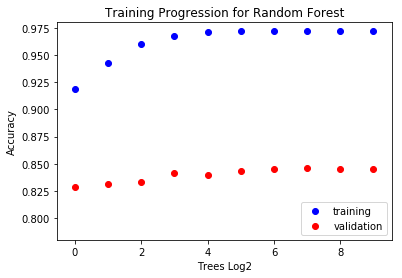

In [37]:
import time
from sklearn.ensemble import RandomForestClassifier
import numpy as np

trees = list(pow(2,np.linspace(1,10,10, dtype = int)))

trainAcc = []
valAcc   = []

for decision_trees_used in trees:
    start = time.time()
    rfc = RandomForestClassifier(n_estimators = decision_trees_used,
                                 n_jobs = -1)
    rfc.fit(trainX, trainY)
    finish = time.time()
    print("Training took",round(finish-start),'seconds using', decision_trees_used, 'trees')
    trainAcc.append(round(rfc.score(trainX, trainY),3))
    valAcc.append(round(rfc.score(valX, valY),3))
    
plt.ylim([0.80,0.98])
plt.scatter(list(range(len(trainAcc))), trainAcc, color = 'blue', label = 'training')
plt.scatter(list(range(len(valAcc))), valAcc, color = 'red', label = 'validation')
plt.ylabel("Accuracy")
plt.xlabel("Trees Log2")
plt.title("Training Progression for Random Forest")
plt.legend(loc = 'lower right')
print("\n Top Validation Acc:", round(max(valAcc),3), 'using', trees[np.argmax(valAcc)], 'trees.')

### Logistic Regression

#### Vanilla

In [147]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver = 'liblinear')
lr.fit(trainX, trainY)
print("Training Acc:  ",round(lr.score(trainX, trainY),3))
print("Validation Acc:",round(lr.score(valX, valY),3))

Training Acc:   0.85
Validation Acc: 0.845


#### LASSO

Max validation Acc: 0.8453 using regularization strength of 0.2


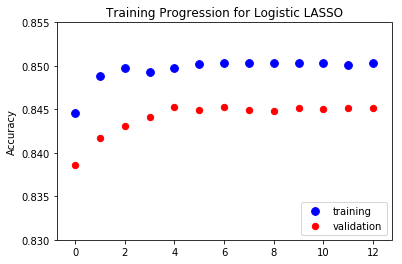

In [156]:
trainAcc = []
valAcc = []
Cs = [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5]  #Inverse of regression strength
for c in Cs:
    lr = LogisticRegression(penalty = 'l1', C = c, solver = 'liblinear')
    lr.fit(trainX, trainY)
    trainAcc.append(round(lr.score(trainX, trainY), 4))
    valAcc.append(  round(lr.score(valX,  valY),  4))
plt.ylim([0.83,.855])
plt.scatter(list(range(len(trainAcc))), trainAcc, color = 'blue', label = 'training',   s = 60)
plt.scatter(list(range(len(valAcc))),   valAcc,   color = 'red',  label = 'validation', s = 40)
plt.ylabel("Accuracy")
plt.title("Training Progression for Logistic LASSO")
plt.legend(loc = 'lower right')
print("Max validation Acc:", max(valAcc), "using regularization strength of", Cs[np.argmax(valAcc)])

#### Ridge

Max validation Acc: 0.8449 using regularization strength of 0.15


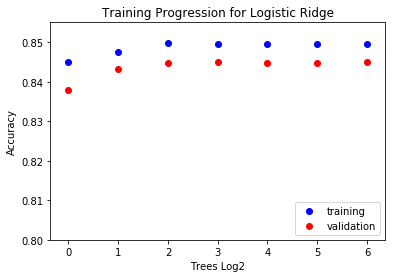

In [158]:
trainAcc = []
valAcc = []
Cs = [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5]  #Inverse of regression strength
for c in Cs:
    lr = LogisticRegression(penalty = 'l2', C = c, solver = 'liblinear')
    lr.fit(trainX, trainY)
    trainAcc.append(round(lr.score(trainX, trainY),4))
    valAcc.append(round(lr.score(valX, valY),4))
plt.ylim([0.80,0.855])
plt.scatter(list(range(len(trainAcc))), trainAcc, color = 'blue', label = 'training')
plt.scatter(list(range(len(valAcc))),   valAcc,   color = 'red',  label = 'validation')
plt.ylabel("Accuracy")
plt.xlabel("Trees Log2")
plt.title("Training Progression for Logistic Ridge")
plt.legend(loc = 'lower right')
print("Max validation Acc:", max(valAcc), "using regularization strength of", Cs[np.argmax(valAcc)])

In [119]:
import tensorflow as tf
import tensorflow.keras as keras

nn = keras.Sequential()
depth = 10
for _ in range(depth):
    nn.add(keras.layers.Dense(128, activation=tf.nn.relu))
    
nn.add(keras.layers.Dense(2, activation=tf.nn.softmax))

nn.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

nn.fit(np.array(trainX), np.array(trainY), epochs = 10)

Epoch 1/10
36178/36178 [==============================] - 9s 261us/step - loss: 1.5670 - acc: 0.7679
Epoch 2/10
36178/36178 [==============================] - 7s 180us/step - loss: 1.5308 - acc: 0.7847
Epoch 3/10
36178/36178 [==============================] - 7s 183us/step - loss: 1.5235 - acc: 0.7874
Epoch 4/10
36178/36178 [==============================] - 7s 181us/step - loss: 1.5223 - acc: 0.7910
Epoch 5/10
36178/36178 [==============================] - 7s 188us/step - loss: 1.5200 - acc: 0.7905
Epoch 6/10
36178/36178 [==============================] - 7s 183us/step - loss: 1.5155 - acc: 0.7914
Epoch 7/10
36178/36178 [==============================] - 7s 185us/step - loss: 1.5167 - acc: 0.7927
Epoch 8/10
36178/36178 [==============================] - 7s 200us/step - loss: 1.5161 - acc: 0.7927
Epoch 9/10
36178/36178 [==============================] - 7s 183us/step - loss: 1.5146 - acc: 0.7937
Epoch 10/10
36178/36178 [==============================] - 7s 199us/step - loss: 1.5133 - a